<a href="https://colab.research.google.com/github/savinduharith-SDL/YOLO_HSI/blob/master/7_1_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install + import essentials (updated)
!pip -q install --upgrade torch torchvision tqdm pyyaml pillow matplotlib torchmetrics scikit-learn

import torch, torchvision, yaml, json, random, math, pathlib, os, cv2, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm2d
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from torchvision.ops import nms
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A

print("torch", torch.__version__, "torchvision", torchvision.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
#@title Project & data paths
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root = pathlib.Path("/content/drive/MyDrive/Research/yolo_from_scratch")
data_root = root / "data"                        # images/, labels/, dataset.yaml live here
for d in ["checkpoints", "logs", "outputs"]:
    (root / d).mkdir(exist_ok=True, parents=True)
print("Root:", root)
yaml_path = data_root / "dataset.yaml"

Mounted at /content/drive
Root: /content/drive/MyDrive/Research/yolo_from_scratch


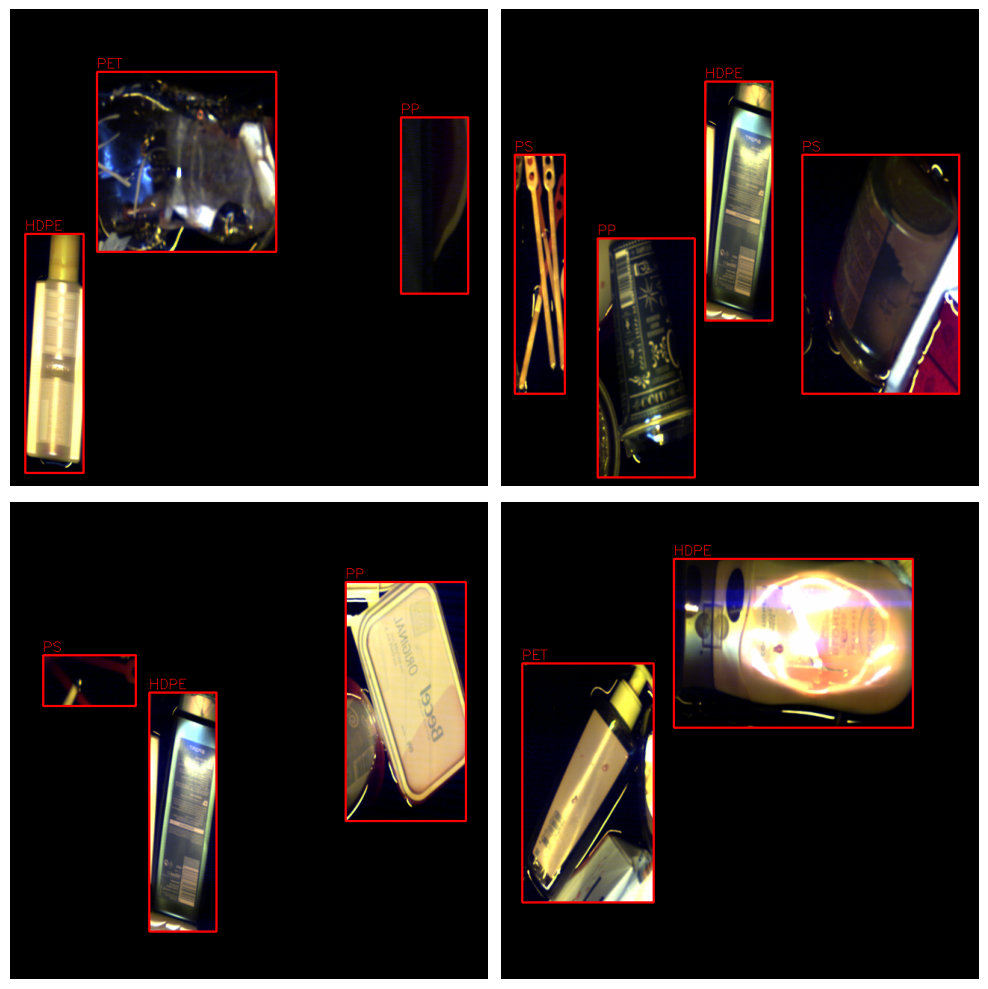

In [3]:
#@title Sanity check: images with boxes - befoe transformation
import random, cv2, matplotlib.pyplot as plt

# load dataset.yaml
base = yaml_path.parent
with open(yaml_path) as f:
    cfg = yaml.safe_load(f)

# image and label folders
img_dir = base / cfg["train"]                          # e.g. data/images/train
lbl_dir = base / cfg["train"].replace("images", "labels")  # e.g. data/labels/train

# pick 4 random images
files = list(img_dir.glob("*.*"))
random.shuffle(files)
sel = files[:4]

# plot in 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), sel):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    # read corresponding label file
    lbl_path = lbl_dir / f"{img_path.stem}.txt"
    with open(lbl_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)
            # draw box and class name
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, cfg["names"][int(cls)], (x1, max(0, y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()

In [4]:
#@title Anchor-Box Clustering & Sanity Check
# Load all ground-truth box widths/heights (normalized) from train labels
import numpy as np
from sklearn.cluster import KMeans

label_dir = data_root / "labels" / "train"
all_boxes = []
for lbl_path in label_dir.glob("*.txt"):
    with open(lbl_path) as f:
        for line in f:
            _, _, _, bw, bh = map(float, line.split())
            all_boxes.append([bw, bh])
all_boxes = np.array(all_boxes)

# Number of anchors to generate
NUM_ANCHORS = 9

# Run K-Means on (bw, bh)
kmeans = KMeans(n_clusters=NUM_ANCHORS, random_state=42)
kmeans.fit(all_boxes)
anchors = kmeans.cluster_centers_

# Sort anchors by width for consistency
anchors = anchors[np.argsort(anchors[:, 0])]
ANCHORS = anchors.tolist()
print(f"Computed {NUM_ANCHORS} anchors (normalized w,h):")
for i, (w, h) in enumerate(ANCHORS, 1):
    print(f"  Anchor {i}: ({w:.4f}, {h:.4f})")

# Sanity check: compute average IoU between each GT box and its closest anchor
def bbox_iou_wh(box, anchor):
    inter_w = min(box[0], anchor[0])
    inter_h = min(box[1], anchor[1])
    inter = inter_w * inter_h
    union = box[0] * box[1] + anchor[0] * anchor[1] - inter
    return inter / (union + 1e-6)

ious = []
for box in all_boxes:
    best_iou = max(bbox_iou_wh(box, anc) for anc in anchors)
    ious.append(best_iou)
avg_iou = float(np.mean(ious))
print(f"Average IoU between GT boxes and nearest anchor: {avg_iou:.4f}")

Computed 9 anchors (normalized w,h):
  Anchor 1: (0.0975, 0.4930)
  Anchor 2: (0.1116, 0.3519)
  Anchor 3: (0.1320, 0.1187)
  Anchor 4: (0.1398, 0.4994)
  Anchor 5: (0.2238, 0.5000)
  Anchor 6: (0.3036, 0.4920)
  Anchor 7: (0.3772, 0.3462)
  Anchor 8: (0.4031, 0.5000)
  Anchor 9: (0.5000, 0.3312)
Average IoU between GT boxes and nearest anchor: 0.8745


In [5]:
#@title Config flags (updated)
with open(yaml_path) as f:
    ds_cfg = yaml.safe_load(f)

# Classes
CLASS_NAMES  = ds_cfg["names"]
C            = len(CLASS_NAMES)    # number of classes

# Grid & Anchors
S            = 7                    # grid size (7×7)
NUM_ANCHORS  = len(ANCHORS)         # now dynamic based on your k-means
B            = NUM_ANCHORS         # boxes per cell → number of anchors

# Multi-scale training sizes (in px)
MULTI_SCALES = list(range(320, 608+1, 32))  # [320, 352, …, 608]

# Default input size
IMAGE_SIZE   = (448, 448)

# Training hyperparameters
BATCH_SIZE    = 64
EPOCHS        = 100
LEARNING_RATE = 1e-4
EPSILON       = 1e-6

# Sanity printout
print(f"Classes ({C}): {CLASS_NAMES}")
print(f"Grid: {S}×{S}, Anchors per cell: {B}")
print(f"Anchors (w,h): {ANCHORS}")
print(f"Multi-scale sizes: {MULTI_SCALES}")

Classes (5): ['HDPE', 'LDPE', 'PET', 'PP', 'PS']
Grid: 7×7, Anchors per cell: 9
Anchors (w,h): [[0.09750022499999997, 0.49296875000000007], [0.11163775862068964, 0.35188558620689653], [0.1319603636363636, 0.11874999999999991], [0.13984362500000003, 0.49937500000000007], [0.22384873684210527, 0.5000000000000001], [0.303596679245283, 0.4920106603773585], [0.37722063157894736, 0.34621736842105266], [0.403125, 0.5], [0.49999999999999994, 0.33116562162162155]]
Multi-scale sizes: [320, 352, 384, 416, 448, 480, 512, 544, 576, 608]


In [6]:
#@title Utility helpers

def bbox_attr(t, idx):
    return t[..., C + idx::5]

def bbox_to_coords(t):
    w = bbox_attr(t, 2); h = bbox_attr(t, 3)
    x = bbox_attr(t, 0); y = bbox_attr(t, 1)
    x1 = x - w/2; y1 = y - h/2
    x2 = x + w/2; y2 = y + h/2
    return torch.stack((x1, y1), dim=-1), torch.stack((x2, y2), dim=-1)

def get_iou(p, a):
    p_tl, p_br = bbox_to_coords(p)
    a_tl, a_br = bbox_to_coords(a)
    tl = torch.maximum(p_tl.unsqueeze(-2), a_tl.unsqueeze(-3))
    br = torch.minimum(p_br.unsqueeze(-2), a_br.unsqueeze(-3))
    inter = (br - tl).clamp(min=0)
    inter_area = inter[...,0] * inter[...,1]

    p_area = bbox_attr(p,2) * bbox_attr(p,3)
    a_area = bbox_attr(a,2) * bbox_attr(a,3)
    union = p_area.unsqueeze(-1) + a_area.unsqueeze(-2) - inter_area
    union = torch.where(union==0, torch.full_like(union, EPSILON), union)
    return inter_area / union

def plot_boxes(img_tensor, label_tensor, conf_thres=0.25):
    img = (img_tensor.permute(1,2,0).cpu().numpy()*255).astype(np.uint8).copy()
    h, w = img.shape[:2]
    gxs, gys = w/S, h/S

    for i in range(S):
        for j in range(S):
            cell = label_tensor[i,j]
            conf = cell[C+4]
            if conf <= conf_thres: continue

            bx,by,bw,bh = cell[C:C+4]
            cls = cell[:C].argmax().item()

            bw *= w;  bh *= h
            cx = (j + bx) * gxs
            cy = (i + by) * gys
            x1, y1 = int(cx-bw/2), int(cy-bh/2)
            x2, y2 = int(cx+bw/2), int(cy+bh/2)

            cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(img, CLASS_NAMES[cls], (x1, max(0,y1-4)),
                        cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1)
    plt.figure(figsize=(5,5)); plt.imshow(img); plt.axis('off')

In [7]:
import random
import numpy as np
import cv2
import torchvision
import torch
from torch.utils.data import Dataset

class YoloFolderDataset(Dataset):
    def __init__(self, split, augment=False,
                 mosaic_prob=0.5, mixup_prob=0.3, cutmix_prob=0.2, copypaste_prob=0.15,
                 perspective_prob=0.2, normalize=True):
        super().__init__()
        img_dir = data_root / "images" / split
        lbl_dir = data_root / "labels" / split
        self.img_files    = sorted([*img_dir.glob("*.jpg"), *img_dir.glob("*.png")])
        self.lbl_dir      = lbl_dir
        self.to_tensor    = torchvision.transforms.ToTensor()
        self.augment      = augment
        self.mosaic_prob  = mosaic_prob
        self.mixup_prob   = mixup_prob
        self.cutmix_prob  = cutmix_prob
        self.copypaste_prob = copypaste_prob
        self.perspective_prob = perspective_prob

        # grid dims (must be updated externally if IMAGE_SIZE changes)
        self.Gh = IMAGE_SIZE[0] // 32
        self.Gw = IMAGE_SIZE[1] // 32

        # anchors as tensor for IoU / assignment
        self.anchors = torch.tensor(ANCHORS, dtype=torch.float32)
        self.A       = self.anchors.size(0)

    def __len__(self):
        return len(self.img_files)

    def load_single(self, idx):
        img_path = self.img_files[idx]
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        labels = []
        with open(self.lbl_dir / f"{img_path.stem}.txt") as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.split())
                labels.append((int(cls), xc, yc, bw, bh))
        return img, labels

    def load_mosaic(self, idx):
        indices = [idx] + random.sample(range(len(self.img_files)), 3)
        full_h, full_w = IMAGE_SIZE
        half_h, half_w = full_h // 2, full_w // 2
        mosaic_img    = np.zeros((full_h, full_w, 3), dtype=np.uint8)
        mosaic_labels = []
        offsets = [(0, 0), (0, half_w), (half_h, 0), (half_h, half_w)]
        for i, (dy, dx) in enumerate(offsets):
            img_i, lbl_i = self.load_single(indices[i])
            img_resized = cv2.resize(img_i, (half_w, half_h))
            mosaic_img[dy:dy+half_h, dx:dx+half_w] = img_resized
            for cls, xc, yc, bw, bh in lbl_i:
                new_xc = (xc * half_w + dx) / full_w
                new_yc = (yc * half_h + dy) / full_h
                new_bw = bw * (half_w / full_w)
                new_bh = bh * (half_h / full_h)
                mosaic_labels.append((cls, new_xc, new_yc, new_bw, new_bh))
        return mosaic_img, mosaic_labels

    def random_perspective(self, img, labels, degrees=10, translate=0.1, scale=0.1, shear=10):
        # Only for demonstration; you may replace with albumentations for more power.
        h, w = img.shape[:2]
        # Center, rotation, scale
        angle = random.uniform(-degrees, degrees)
        scale_factor = 1.0 + random.uniform(-scale, scale)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, scale_factor)
        # Translation
        M[0,2] += random.uniform(-translate, translate) * w
        M[1,2] += random.uniform(-translate, translate) * h
        # Shear
        shear_val = random.uniform(-shear, shear)
        M_shear = np.array([[1, math.tan(np.radians(shear_val)), 0], [0,1,0]])
        M_full = M_shear @ np.vstack([M,[0,0,1]])
        img = cv2.warpAffine(img, M_full[:2], (w,h), borderValue=(114,114,114))
        # Transform bboxes
        labels_new = []
        for cls, xc, yc, bw, bh in labels:
            x = xc * w; y = yc * h; bw2 = bw * w / 2; bh2 = bh * h / 2
            pts = np.array([[x-bw2, y-bh2,1], [x+bw2, y-bh2,1], [x-bw2, y+bh2,1], [x+bw2, y+bh2,1]]).T
            pts = M_full @ pts
            x_min, y_min = pts[0].min(), pts[1].min()
            x_max, y_max = pts[0].max(), pts[1].max()
            new_xc = (x_min + x_max)/2 / w
            new_yc = (y_min + y_max)/2 / h
            new_bw = (x_max - x_min)/w
            new_bh = (y_max - y_min)/h
            if 0 < new_xc < 1 and 0 < new_yc < 1 and new_bw > 0 and new_bh > 0:
                labels_new.append((cls, new_xc, new_yc, new_bw, new_bh))
        return img, labels_new

    def mixup(self, img1, labels1, img2, labels2, alpha=0.2):
        lam = np.random.beta(alpha, alpha)
        img = (img1.astype(np.float32) * lam + img2.astype(np.float32) * (1-lam)).astype(np.uint8)
        labels = labels1 + labels2
        return img, labels

    def cutmix(self, img1, labels1, img2, labels2):
        h, w = img1.shape[:2]
        # Random patch
        cut_x = random.randint(0, w - w//2)
        cut_y = random.randint(0, h - h//2)
        patch = img2[cut_y:cut_y+h//2, cut_x:cut_x+w//2]
        img1[cut_y:cut_y+h//2, cut_x:cut_x+w//2] = patch
        # Only keep labels that fall in visible area
        labels = labels1.copy()
        for cls, xc, yc, bw, bh in labels2:
            abs_x, abs_y = int(xc*w), int(yc*h)
            if (cut_x < abs_x < cut_x+w//2) and (cut_y < abs_y < cut_y+h//2):
                labels.append((cls, xc, yc, bw, bh))
        return img1, labels

    def copypaste(self, img1, labels1, img2, labels2, max_instances=2):
        h, w = img1.shape[:2]
        img_cp = img1.copy()
        labels_cp = labels1.copy()
        # Pick a few objects from img2
        sampled = random.sample(labels2, min(max_instances, len(labels2)))
        for cls, xc, yc, bw, bh in sampled:
            x1 = int((xc-bw/2)*w)
            y1 = int((yc-bh/2)*h)
            x2 = int((xc+bw/2)*w)
            y2 = int((yc+bh/2)*h)
            if x1<0 or y1<0 or x2>w or y2>h: continue
            obj_patch = img2[y1:y2, x1:x2].copy()
            # Random location
            rx = random.randint(0, w-(x2-x1))
            ry = random.randint(0, h-(y2-y1))
            img_cp[ry:ry+(y2-y1), rx:rx+(x2-x1)] = obj_patch
            new_xc = (rx + (x2-x1)/2)/w
            new_yc = (ry + (y2-y1)/2)/h
            new_bw = bw
            new_bh = bh
            labels_cp.append((cls, new_xc, new_yc, new_bw, new_bh))
        return img_cp, labels_cp

    def __getitem__(self, idx):
        # Choose basic or mosaic
        if self.augment and random.random() < self.mosaic_prob:
            img, raw_labels = self.load_mosaic(idx)
        else:
            img, raw_labels = self.load_single(idx)
            img = cv2.resize(img, IMAGE_SIZE)

        # Random perspective/rotation/shear
        if self.augment and random.random() < self.perspective_prob:
            img, raw_labels = self.random_perspective(img, raw_labels)

        # MixUp & CutMix
        if self.augment and random.random() < self.mixup_prob:
            idx2 = random.randint(0, len(self.img_files)-1)
            img2, labels2 = self.load_single(idx2)
            img2 = cv2.resize(img2, IMAGE_SIZE)
            img, raw_labels = self.mixup(img, raw_labels, img2, labels2)
        elif self.augment and random.random() < self.cutmix_prob:
            idx2 = random.randint(0, len(self.img_files)-1)
            img2, labels2 = self.load_single(idx2)
            img2 = cv2.resize(img2, IMAGE_SIZE)
            img, raw_labels = self.cutmix(img, raw_labels, img2, labels2)
        # Copy-Paste
        elif self.augment and random.random() < self.copypaste_prob:
            idx2 = random.randint(0, len(self.img_files)-1)
            img2, labels2 = self.load_single(idx2)
            img2 = cv2.resize(img2, IMAGE_SIZE)
            img, raw_labels = self.copypaste(img, raw_labels, img2, labels2)

        img_t = self.to_tensor(img)
        labels = np.zeros((self.Gh, self.Gw, self.A, 5 + C), dtype=np.float32)
        for cls, xc, yc, bw, bh in raw_labels:
            col = int(xc * self.Gw)
            row = int(yc * self.Gh)
            if not (0 <= row < self.Gh and 0 <= col < self.Gw):
                continue
            dx = xc * self.Gw - col
            dy = yc * self.Gh - row
            ious = []
            for anc in self.anchors:
                inter_w = min(anc[0].item(), bw)
                inter_h = min(anc[1].item(), bh)
                inter = inter_w * inter_h
                union = anc[0].item()*anc[1].item() + bw*bh - inter + 1e-6
                ious.append(inter/union)
            a_idx = int(np.argmax(ious))
            tw = math.log(bw / (self.anchors[a_idx,0].item() + 1e-6) + 1e-6)
            th = math.log(bh / (self.anchors[a_idx,1].item() + 1e-6) + 1e-6)
            labels[row, col, a_idx, 0:4] = [dx, dy, tw, th]
            labels[row, col, a_idx, 4]   = 1.0
            labels[row, col, a_idx, 5+cls] = 1.0

        return img_t, torch.from_numpy(labels)

/tmp/ipython-input-8-768390878.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  bw = anchor_w * np.exp(tw)
/tmp/ipython-input-8-768390878.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  bh = anchor_h * np.exp(th)


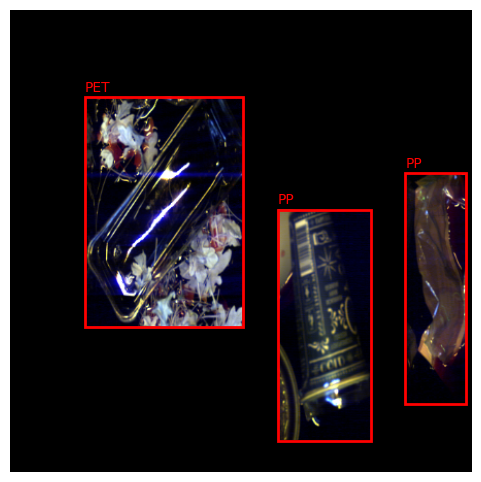

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

#@title 5a  Dataset sanity-check: visualize parsed labels
ds = YoloFolderDataset("train")
img_t, lbl = ds[random.randrange(len(ds))]

# Convert tensor to numpy image
img = (img_t.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
h, w = IMAGE_SIZE

Gh, Gw, A, _ = lbl.shape

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(img)

for i in range(Gh):
    for j in range(Gw):
        for a in range(A):
            if lbl[i, j, a, 4] == 1:
                dx, dy, tw, th = lbl[i, j, a, 0:4]
                anchor_w, anchor_h = ANCHORS[a]
                # Decode box
                cx = (j + dx) / Gw
                cy = (i + dy) / Gh
                bw = anchor_w * np.exp(tw)
                bh = anchor_h * np.exp(th)
                x1 = int((cx - bw/2) * w)
                y1 = int((cy - bh/2) * h)
                x2 = int((cx + bw/2) * w)
                y2 = int((cy + bh/2) * h)
                cls = int(lbl[i, j, a, 5:].argmax().item())

                # Draw
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                     edgecolor='r', facecolor='none', linewidth=2)
                ax.add_patch(rect)
                ax.text(x1, y1-5, CLASS_NAMES[cls], color='r', fontsize=10)

ax.axis('off')
plt.show()

In [9]:
#@title Loss function: Focal + DIoU (no external imports)
import torch.nn.functional as F

def sigmoid_focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='sum'):
    """
    inputs: logits
    targets: same shape, float {0,1}
    """
    prob = torch.sigmoid(inputs)
    ce   = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    p_t  = prob * targets + (1 - prob) * (1 - targets)
    alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    loss = alpha_t * (1 - p_t)**gamma * ce
    if reduction == 'sum':
        return loss.sum()
    if reduction == 'mean':
        return loss.mean()
    return loss

def diou_loss(pred_tl, pred_br, gt_tl, gt_br, eps=1e-6):
    # IoU
    inter_tl = torch.max(pred_tl, gt_tl)
    inter_br = torch.min(pred_br, gt_br)
    inter_wh = (inter_br - inter_tl).clamp(min=0)
    inter_area = inter_wh[...,0] * inter_wh[...,1]
    p_wh = (pred_br - pred_tl).clamp(min=0)
    g_wh = (gt_br   - gt_tl).clamp(min=0)
    union = p_wh[...,0]*p_wh[...,1] + g_wh[...,0]*g_wh[...,1] - inter_area + eps
    iou = inter_area / union

    # center distance
    p_ctr = (pred_tl + pred_br) / 2
    g_ctr = (gt_tl   + gt_br)   / 2
    dist2 = ((p_ctr - g_ctr)**2).sum(dim=-1)

    # enclosing diagonal
    en_tl = torch.min(pred_tl, gt_tl)
    en_br = torch.max(pred_br, gt_br)
    en_wh = (en_br - en_tl).clamp(min=0)
    c2 = (en_wh[...,0]**2 + en_wh[...,1]**2) + eps

    return iou - dist2 / c2

class YoloV2LossFocalDIoU(nn.Module):
    def __init__(self, anchors, l_coord=5.0, l_noobj=0.5, eps=1e-6):
        super().__init__()
        self.anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
        self.A       = self.anchors.size(0)
        self.C       = C
        self.l_coord = l_coord
        self.l_noobj = l_noobj
        self.eps     = eps

    def forward(self, pred, target):
        # pred/target: (N, Gh, Gw, A, 5+C)
        N, Gh, Gw, A, _ = pred.shape

        # build grid
        gy, gx = torch.meshgrid(
            torch.arange(Gh, device=device, dtype=torch.float32),
            torch.arange(Gw, device=device, dtype=torch.float32),
            indexing='ij'
        )
        gx = gx.view(1,Gh,Gw,1).expand(N,Gh,Gw,A)
        gy = gy.view(1,Gh,Gw,1).expand(N,Gh,Gw,A)

        # unpack preds
        tx, ty = torch.sigmoid(pred[...,0]), torch.sigmoid(pred[...,1])
        tw, th = pred[...,2], pred[...,3]
        obj_logits = pred[...,4]
        cls_logits = pred[...,5:]           # (N,Gh,Gw,A,C)

        # unpack targets
        tx_t, ty_t = target[...,0], target[...,1]
        tw_t, th_t = target[...,2], target[...,3]
        obj_t       = target[...,4]
        cls_t       = target[...,5:]        # one-hot

        # anchor dims
        aw = self.anchors[:,0].view(1,1,1,A)
        ah = self.anchors[:,1].view(1,1,1,A)

        # decode to normalized box centers & sizes
        bx   = (gx + tx) / Gw;   by   = (gy + ty) / Gh
        bw   = aw * torch.exp(tw); bh   = ah * torch.exp(th)
        bx_t = (gx + tx_t)/Gw;   by_t = (gy + ty_t)/Gh
        bw_t = aw * torch.exp(tw_t); bh_t = ah * torch.exp(th_t)

        # corner coords for DIoU
        p_tl = torch.stack([bx - bw/2, by - bh/2], dim=-1)
        p_br = torch.stack([bx + bw/2, by + bh/2], dim=-1)
        g_tl = torch.stack([bx_t - bw_t/2, by_t - bh_t/2], dim=-1)
        g_br = torch.stack([bx_t + bw_t/2, by_t + bh_t/2], dim=-1)

        # masks
        obj_mask   = obj_t.bool()      # where objects exist
        noobj_mask = ~obj_mask

        # 1) DIoU box loss (only positives)
        diou = diou_loss(p_tl, p_br, g_tl, g_br, eps=self.eps)
        loss_box = (1 - diou)[obj_mask].sum()

        # 2) Focal objectness loss
        loss_obj   = sigmoid_focal_loss(obj_logits[obj_mask], obj_t[obj_mask], reduction='sum')
        loss_noobj = self.l_noobj * sigmoid_focal_loss(
                            obj_logits[noobj_mask],
                            obj_t[noobj_mask],
                            reduction='sum'
                        )

        # 3) Focal classification loss (only positives)
        cls_pred   = cls_logits[obj_mask].view(-1, self.C)
        cls_target = cls_t[obj_mask].float().view(-1, self.C)
        loss_cls   = sigmoid_focal_loss(cls_pred, cls_target, reduction='sum')

        total = self.l_coord * loss_box + loss_obj + loss_noobj + loss_cls
        return total / N

# Sanity check (run after reloading runtime and imports)
criterion = YoloV2LossFocalDIoU(anchors=ANCHORS).to(device)
Gh, Gw = IMAGE_SIZE[0]//32, IMAGE_SIZE[1]//32
dummy_p = torch.randn(2, Gh,Gw,NUM_ANCHORS,5+C, device=device)
dummy_t = torch.zeros_like(dummy_p)
dummy_t[0,3,3,0,:] = torch.tensor([0.5,0.5,0.0,0.0,1.0] + [0]*C, device=device)
print("Dummy loss (Focal+DIoU):", criterion(dummy_p, dummy_t))

Dummy loss (Focal+DIoU): tensor(239.4192, device='cuda:0')


In [10]:
#@title Model definition: enhanced head with SPP + SiLU + SE + lighter Dropout
import torch.nn.functional as F

class Reorg(nn.Module):
    """YOLOv2 passthrough reorg (stride=2)."""
    def __init__(self, stride=2):
        super().__init__()
        self.stride = stride
    def forward(self, x):
        B, C, H, W = x.size()
        s = self.stride
        x = x.view(B, C, H//s, s, W//s, s)
        x = x.permute(0,1,3,5,2,4).contiguous()
        return x.view(B, C*(s**2), H//s, W//s)

class SPP(nn.Module):
    """Spatial Pyramid Pooling (5×5, 9×9, 13×13)."""
    def __init__(self):
        super().__init__()
        self.pool1 = nn.MaxPool2d(5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(9, stride=1, padding=4)
        self.pool3 = nn.MaxPool2d(13, stride=1, padding=6)
    def forward(self, x):
        return torch.cat([x, self.pool1(x), self.pool2(x), self.pool3(x)], dim=1)

class SELayer(nn.Module):
    """Squeeze-and-Excitation channel attention."""
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel//reduction, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(channel//reduction, channel,    1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)

class YOLOv2ResNetDropoutEnhanced(nn.Module):
    def __init__(self, num_anchors=NUM_ANCHORS, num_classes=C):
        super().__init__()
        resnet = torchvision.models.resnet50(weights='DEFAULT')
        # Freeze all but layer4
        for p in resnet.parameters():
            p.requires_grad = False
        for p in resnet.layer4.parameters():
            p.requires_grad = True

        # Backbone & passthrough
        self.stem      = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2
        )
        self.layer3   = resnet.layer3
        self.layer4   = resnet.layer4

        # SPP on layer4 output
        self.conv_spp = nn.Conv2d(2048, 512, kernel_size=1, bias=False)
        self.spp      = SPP()  # output channels: 512*4 = 2048

        # Passthrough from layer3
        self.reduction = nn.Conv2d(1024, 256, 1, 1, 0)
        self.reorg     = Reorg(2)

        # Enhanced head
        in_ch = 2048 + 256*4  # 2048 from SPP + 1024 from reorg
        self.head = nn.Sequential(
            nn.Conv2d(in_ch, 1024, 3, padding=1, bias=False),
            BatchNorm2d(1024), nn.SiLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(1024, 1024, 3, padding=1, bias=False),
            BatchNorm2d(1024), nn.SiLU(inplace=True),
            SELayer(1024),
            nn.Conv2d(1024, num_anchors*(5+num_classes), 1)
        )

    def forward(self, x):
        x = self.stem(x)
        p = self.layer3(x)
        x = self.layer4(p)
        # SPP path
        x = self.conv_spp(x)
        x = self.spp(x)
        # passthrough path
        p = self.reorg(self.reduction(p))
        # detection head
        y = self.head(torch.cat([x, p], dim=1))
        B, _, Gh, Gw = y.shape
        y = y.view(B, NUM_ANCHORS, 5+C, Gh, Gw) \
             .permute(0,3,4,1,2).contiguous()

        tx_ty      = torch.sigmoid(y[...,0:2])
        tw_th      = torch.exp(y[...,2:4].clamp(-5,5))
        obj_logits = y[...,4:5]
        cls_logits = y[...,5:]
        return torch.cat([tx_ty, tw_th, obj_logits, cls_logits], dim=-1)

# instantiate & verify
model = YOLOv2ResNetDropoutEnhanced().to(device)
print("Model params:", sum(p.numel() for p in model.parameters()))
print("Trainable:", sum(p.numel() for p in model.parameters() if p.requires_grad))
dummy = torch.randn(2,3,*IMAGE_SIZE, device=device)
print("Output:", model(dummy).shape)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 48.9MB/s]


Model params: 62796250
Trainable: 54252954
Output: torch.Size([2, 14, 14, 9, 10])


In [11]:
#@title 9  Dataloaders
train_ds = YoloFolderDataset("train", augment=True)
val_ds   = YoloFolderDataset("val",   augment=False)
train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,num_workers=2, pin_memory=True)
print(len(train_ld), "train batches |", len(val_ld), "val batches")

3 train batches | 1 val batches


In [12]:
# # 1) Specify the checkpoint path
# ckpt_path = "/content/drive/MyDrive/Research/yolo_from_scratch/checkpoints/yolov2_epoch112.pt"  # change epoch as needed

# # 2) Re-instantiate the model (must match the class you used when saving)
# model = YOLOv2ResNetDropout().to(device)   # or YOLOv2ResNetFinetune(), etc.

# # 3) Load state dict
# state = torch.load(ckpt_path, map_location=device)
# model.load_state_dict(state)

In [13]:
#@title 10b  Training loop: SGD + warm-up + cosine annealing
import torch.optim as optim

# 1) Use SGD
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=1e-3, momentum=0.9, weight_decay=5e-4)

# 2) Scheduler: warm-up for 2 epochs, then cosine anneal over EPOCHS
def lr_lambda(epoch):
    if epoch < 2:
        return (epoch + 1) / 2  # linear from 0.5→1
    else:
        return 0.5 * (1 + math.cos(math.pi * (epoch-2) / (EPOCHS-2)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

criterion = YoloV2LossFocalDIoU(anchors=ANCHORS).to(device)

for epoch in range(EPOCHS):
    # multi-scale & update grids
    new_size = random.choice(MULTI_SCALES)
    IMAGE_SIZE = (new_size, new_size)
    train_ds.Gh = train_ds.Gw = new_size//32
    val_ds.Gh   = val_ds.Gw   = new_size//32

    print(f"\n=== Epoch {epoch} @ {new_size}×{new_size}, LR={optimizer.param_groups[0]['lr']:.2e} ===")
    model.train()
    running = 0.0
    for imgs, lbls in tqdm(train_ld, desc=f"Epoch {epoch}"):
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        pred = model(imgs)
        loss = criterion(pred, lbls)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()
        running += loss.item()
    print(f"Train loss: {running/len(train_ld):.4f}")

    # step scheduler
    scheduler.step()

    # validation & checkpoint every 2 epochs
    if epoch % 2 == 0:
        model.eval()
        v = 0.0
        with torch.no_grad():
            for imgs, lbls in val_ld:
                v += criterion(model(imgs.to(device)), lbls.to(device)).item()
        v /= len(val_ld)
        print(f"Val loss: {v:.4f}")
        torch.save(model.state_dict(), root/"checkpoints"/f"yolov2_epoch{epoch}.pt")


=== Epoch 0 @ 384×384, LR=5.00e-04 ===


Epoch 0: 100%|██████████| 3/3 [00:19<00:00,  6.45s/it]

Train loss: 125.2750


Val loss: 99.4888

=== Epoch 1 @ 576×576, LR=1.00e-03 ===


Epoch 1: 100%|██████████| 3/3 [00:13<00:00,  4.37s/it]


Train loss: 219.0314

=== Epoch 2 @ 576×576, LR=1.00e-03 ===


Epoch 2: 100%|██████████| 3/3 [00:13<00:00,  4.62s/it]

Train loss: 177.3803


Val loss: 196.2585

=== Epoch 3 @ 320×320, LR=1.00e-03 ===


Epoch 3: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


Train loss: 68.5170

=== Epoch 4 @ 352×352, LR=9.99e-04 ===


Epoch 4: 100%|██████████| 3/3 [00:12<00:00,  4.20s/it]

Train loss: 62.9234


Val loss: 73.6168

=== Epoch 5 @ 352×352, LR=9.98e-04 ===


Epoch 5: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


Train loss: 49.3296

=== Epoch 6 @ 416×416, LR=9.96e-04 ===


Epoch 6: 100%|██████████| 3/3 [00:12<00:00,  4.28s/it]

Train loss: 52.9540


Val loss: 56.3535

=== Epoch 7 @ 320×320, LR=9.94e-04 ===


Epoch 7: 100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


Train loss: 37.6817

=== Epoch 8 @ 608×608, LR=9.91e-04 ===


Epoch 8: 100%|██████████| 3/3 [00:16<00:00,  5.56s/it]

Train loss: 43.1539


Val loss: 35.8913

=== Epoch 9 @ 480×480, LR=9.87e-04 ===


Epoch 9: 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]


Train loss: 39.5998

=== Epoch 10 @ 576×576, LR=9.84e-04 ===


Epoch 10: 100%|██████████| 3/3 [00:15<00:00,  5.30s/it]

Train loss: 38.5447


Val loss: 25.4483

=== Epoch 11 @ 608×608, LR=9.79e-04 ===


Epoch 11: 100%|██████████| 3/3 [00:11<00:00,  3.89s/it]


Train loss: 33.2873

=== Epoch 12 @ 480×480, LR=9.75e-04 ===


Epoch 12: 100%|██████████| 3/3 [00:11<00:00,  4.00s/it]

Train loss: 34.3380


Val loss: 13.7839

=== Epoch 13 @ 448×448, LR=9.69e-04 ===


Epoch 13: 100%|██████████| 3/3 [00:09<00:00,  3.16s/it]


Train loss: 30.8044

=== Epoch 14 @ 416×416, LR=9.63e-04 ===


Epoch 14: 100%|██████████| 3/3 [00:13<00:00,  4.38s/it]

Train loss: 29.3771


Val loss: 9.7920

=== Epoch 15 @ 448×448, LR=9.57e-04 ===


Epoch 15: 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]


Train loss: 26.4657

=== Epoch 16 @ 448×448, LR=9.50e-04 ===


Epoch 16: 100%|██████████| 3/3 [00:14<00:00,  4.68s/it]

Train loss: 27.5092


Val loss: 8.1160

=== Epoch 17 @ 608×608, LR=9.43e-04 ===


Epoch 17: 100%|██████████| 3/3 [00:13<00:00,  4.33s/it]


Train loss: 24.8591

=== Epoch 18 @ 608×608, LR=9.36e-04 ===


Epoch 18: 100%|██████████| 3/3 [00:14<00:00,  4.99s/it]

Train loss: 25.0732


Val loss: 8.5679

=== Epoch 19 @ 576×576, LR=9.28e-04 ===


Epoch 19: 100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


Train loss: 26.2496

=== Epoch 20 @ 512×512, LR=9.19e-04 ===


Epoch 20: 100%|██████████| 3/3 [00:13<00:00,  4.57s/it]

Train loss: 24.8161


Val loss: 7.9207

=== Epoch 21 @ 352×352, LR=9.10e-04 ===


Epoch 21: 100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


Train loss: 32.2654

=== Epoch 22 @ 480×480, LR=9.01e-04 ===


Epoch 22: 100%|██████████| 3/3 [00:14<00:00,  4.80s/it]

Train loss: 23.8405


Val loss: 6.4763

=== Epoch 23 @ 608×608, LR=8.91e-04 ===


Epoch 23: 100%|██████████| 3/3 [00:13<00:00,  4.50s/it]


Train loss: 23.5903

=== Epoch 24 @ 416×416, LR=8.81e-04 ===


Epoch 24: 100%|██████████| 3/3 [00:12<00:00,  4.21s/it]

Train loss: 26.4529


Val loss: 6.3712

=== Epoch 25 @ 416×416, LR=8.70e-04 ===


Epoch 25: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


Train loss: 27.3654

=== Epoch 26 @ 416×416, LR=8.59e-04 ===


Epoch 26: 100%|██████████| 3/3 [00:13<00:00,  4.49s/it]

Train loss: 25.0242


Val loss: 6.6359

=== Epoch 27 @ 320×320, LR=8.48e-04 ===


Epoch 27: 100%|██████████| 3/3 [00:12<00:00,  4.25s/it]


Train loss: 29.9270

=== Epoch 28 @ 544×544, LR=8.36e-04 ===


Epoch 28: 100%|██████████| 3/3 [00:12<00:00,  4.14s/it]

Train loss: 22.4152


Val loss: 5.3675

=== Epoch 29 @ 544×544, LR=8.24e-04 ===


Epoch 29: 100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


Train loss: 20.0341

=== Epoch 30 @ 352×352, LR=8.12e-04 ===


Epoch 30: 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

Train loss: 23.7069


Val loss: 6.3650

=== Epoch 31 @ 512×512, LR=7.99e-04 ===


Epoch 31: 100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


Train loss: 22.4253

=== Epoch 32 @ 480×480, LR=7.86e-04 ===


Epoch 32: 100%|██████████| 3/3 [00:14<00:00,  4.80s/it]

Train loss: 20.8424


Val loss: 6.3752

=== Epoch 33 @ 608×608, LR=7.73e-04 ===


Epoch 33: 100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


Train loss: 21.8347

=== Epoch 34 @ 608×608, LR=7.59e-04 ===


Epoch 34: 100%|██████████| 3/3 [00:13<00:00,  4.35s/it]

Train loss: 21.8245


Val loss: 5.3762

=== Epoch 35 @ 608×608, LR=7.45e-04 ===


Epoch 35: 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]


Train loss: 24.2253

=== Epoch 36 @ 384×384, LR=7.31e-04 ===


Epoch 36: 100%|██████████| 3/3 [00:10<00:00,  3.56s/it]

Train loss: 22.6371


Val loss: 7.4150

=== Epoch 37 @ 608×608, LR=7.17e-04 ===


Epoch 37: 100%|██████████| 3/3 [00:12<00:00,  4.32s/it]


Train loss: 22.6208

=== Epoch 38 @ 320×320, LR=7.02e-04 ===


Epoch 38: 100%|██████████| 3/3 [00:11<00:00,  3.67s/it]

Train loss: 29.8746


Val loss: 7.3429

=== Epoch 39 @ 320×320, LR=6.88e-04 ===


Epoch 39: 100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


Train loss: 25.8120

=== Epoch 40 @ 352×352, LR=6.73e-04 ===


Epoch 40: 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]

Train loss: 22.6138


Val loss: 6.4528

=== Epoch 41 @ 544×544, LR=6.58e-04 ===


Epoch 41: 100%|██████████| 3/3 [00:12<00:00,  4.04s/it]


Train loss: 22.8603

=== Epoch 42 @ 480×480, LR=6.42e-04 ===


Epoch 42: 100%|██████████| 3/3 [00:13<00:00,  4.46s/it]

Train loss: 23.2403


Val loss: 5.1715

=== Epoch 43 @ 416×416, LR=6.27e-04 ===


Epoch 43: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]


Train loss: 21.7908

=== Epoch 44 @ 544×544, LR=6.11e-04 ===


Epoch 44: 100%|██████████| 3/3 [00:15<00:00,  5.32s/it]

Train loss: 21.6468


Val loss: 5.4739

=== Epoch 45 @ 576×576, LR=5.96e-04 ===


Epoch 45: 100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


Train loss: 23.1774

=== Epoch 46 @ 448×448, LR=5.80e-04 ===


Epoch 46: 100%|██████████| 3/3 [00:10<00:00,  3.38s/it]

Train loss: 23.5284


Val loss: 5.3919

=== Epoch 47 @ 448×448, LR=5.64e-04 ===


Epoch 47: 100%|██████████| 3/3 [00:09<00:00,  3.16s/it]


Train loss: 22.3357

=== Epoch 48 @ 352×352, LR=5.48e-04 ===


Epoch 48: 100%|██████████| 3/3 [00:13<00:00,  4.35s/it]

Train loss: 22.4427


Val loss: 5.7954

=== Epoch 49 @ 448×448, LR=5.32e-04 ===


Epoch 49: 100%|██████████| 3/3 [00:08<00:00,  2.81s/it]


Train loss: 21.0144

=== Epoch 50 @ 384×384, LR=5.16e-04 ===


Epoch 50: 100%|██████████| 3/3 [00:12<00:00,  4.12s/it]

Train loss: 25.8814


Val loss: 5.8220

=== Epoch 51 @ 320×320, LR=5.00e-04 ===


Epoch 51: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


Train loss: 25.0534

=== Epoch 52 @ 416×416, LR=4.84e-04 ===


Epoch 52: 100%|██████████| 3/3 [00:13<00:00,  4.59s/it]

Train loss: 24.4271


Val loss: 5.3494

=== Epoch 53 @ 448×448, LR=4.68e-04 ===


Epoch 53: 100%|██████████| 3/3 [00:09<00:00,  3.26s/it]


Train loss: 19.8092

=== Epoch 54 @ 384×384, LR=4.52e-04 ===


Epoch 54: 100%|██████████| 3/3 [00:12<00:00,  4.31s/it]

Train loss: 25.5418


Val loss: 5.7399

=== Epoch 55 @ 480×480, LR=4.36e-04 ===


Epoch 55: 100%|██████████| 3/3 [00:10<00:00,  3.35s/it]


Train loss: 20.6697

=== Epoch 56 @ 608×608, LR=4.20e-04 ===


Epoch 56: 100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

Train loss: 20.5668


Val loss: 5.0169

=== Epoch 57 @ 480×480, LR=4.04e-04 ===


Epoch 57: 100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


Train loss: 20.6471

=== Epoch 58 @ 608×608, LR=3.89e-04 ===


Epoch 58: 100%|██████████| 3/3 [00:17<00:00,  5.70s/it]

Train loss: 20.9532


Val loss: 5.1321

=== Epoch 59 @ 544×544, LR=3.73e-04 ===


Epoch 59: 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]


Train loss: 20.8359

=== Epoch 60 @ 384×384, LR=3.58e-04 ===


Epoch 60: 100%|██████████| 3/3 [00:11<00:00,  3.91s/it]

Train loss: 23.9902


Val loss: 5.9632

=== Epoch 61 @ 608×608, LR=3.42e-04 ===


Epoch 61: 100%|██████████| 3/3 [00:11<00:00,  3.91s/it]


Train loss: 21.0172

=== Epoch 62 @ 608×608, LR=3.27e-04 ===


Epoch 62: 100%|██████████| 3/3 [00:14<00:00,  4.98s/it]

Train loss: 21.9973


Val loss: 5.0000

=== Epoch 63 @ 576×576, LR=3.12e-04 ===


Epoch 63: 100%|██████████| 3/3 [00:10<00:00,  3.60s/it]


Train loss: 22.9954

=== Epoch 64 @ 576×576, LR=2.98e-04 ===


Epoch 64: 100%|██████████| 3/3 [00:14<00:00,  4.73s/it]

Train loss: 21.7646


Val loss: 5.0884

=== Epoch 65 @ 576×576, LR=2.83e-04 ===


Epoch 65: 100%|██████████| 3/3 [00:10<00:00,  3.63s/it]


Train loss: 19.2183

=== Epoch 66 @ 448×448, LR=2.69e-04 ===


Epoch 66: 100%|██████████| 3/3 [00:13<00:00,  4.34s/it]

Train loss: 23.4815


Val loss: 5.2425

=== Epoch 67 @ 480×480, LR=2.55e-04 ===


Epoch 67: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]


Train loss: 23.7578

=== Epoch 68 @ 416×416, LR=2.41e-04 ===


Epoch 68: 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]

Train loss: 25.1316


Val loss: 5.2806

=== Epoch 69 @ 576×576, LR=2.27e-04 ===


Epoch 69: 100%|██████████| 3/3 [00:10<00:00,  3.61s/it]


Train loss: 19.4666

=== Epoch 70 @ 384×384, LR=2.14e-04 ===


Epoch 70: 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]

Train loss: 21.4096


Val loss: 5.7610

=== Epoch 71 @ 320×320, LR=2.01e-04 ===


Epoch 71: 100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Train loss: 23.0930

=== Epoch 72 @ 480×480, LR=1.88e-04 ===


Epoch 72: 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]

Train loss: 19.0491


Val loss: 5.0176

=== Epoch 73 @ 480×480, LR=1.76e-04 ===


Epoch 73: 100%|██████████| 3/3 [00:09<00:00,  3.00s/it]


Train loss: 19.8075

=== Epoch 74 @ 512×512, LR=1.64e-04 ===


Epoch 74: 100%|██████████| 3/3 [00:14<00:00,  4.73s/it]

Train loss: 20.5117


Val loss: 4.5117

=== Epoch 75 @ 576×576, LR=1.52e-04 ===


Epoch 75: 100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


Train loss: 20.0432

=== Epoch 76 @ 480×480, LR=1.41e-04 ===


Epoch 76: 100%|██████████| 3/3 [00:13<00:00,  4.66s/it]

Train loss: 20.8234


Val loss: 4.8576

=== Epoch 77 @ 448×448, LR=1.30e-04 ===


Epoch 77: 100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Train loss: 20.3617

=== Epoch 78 @ 448×448, LR=1.19e-04 ===


Epoch 78: 100%|██████████| 3/3 [00:13<00:00,  4.51s/it]

Train loss: 17.0108


Val loss: 4.9932

=== Epoch 79 @ 384×384, LR=1.09e-04 ===


Epoch 79: 100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


Train loss: 21.4685

=== Epoch 80 @ 608×608, LR=9.93e-05 ===


Epoch 80: 100%|██████████| 3/3 [00:17<00:00,  5.72s/it]

Train loss: 18.6781


Val loss: 5.0485

=== Epoch 81 @ 544×544, LR=8.99e-05 ===


Epoch 81: 100%|██████████| 3/3 [00:11<00:00,  3.96s/it]


Train loss: 18.9712

=== Epoch 82 @ 320×320, LR=8.10e-05 ===


Epoch 82: 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

Train loss: 21.4900


Val loss: 6.6886

=== Epoch 83 @ 448×448, LR=7.24e-05 ===


Epoch 83: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


Train loss: 20.0811

=== Epoch 84 @ 416×416, LR=6.43e-05 ===


Epoch 84: 100%|██████████| 3/3 [00:12<00:00,  4.25s/it]

Train loss: 22.5407


Val loss: 5.0424

=== Epoch 85 @ 416×416, LR=5.67e-05 ===


Epoch 85: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


Train loss: 22.6368

=== Epoch 86 @ 352×352, LR=4.95e-05 ===


Epoch 86: 100%|██████████| 3/3 [00:12<00:00,  4.28s/it]

Train loss: 24.6622


Val loss: 5.6508

=== Epoch 87 @ 576×576, LR=4.28e-05 ===


Epoch 87: 100%|██████████| 3/3 [00:12<00:00,  4.03s/it]


Train loss: 18.6032

=== Epoch 88 @ 320×320, LR=3.65e-05 ===


Epoch 88: 100%|██████████| 3/3 [00:11<00:00,  3.96s/it]

Train loss: 24.8841


Val loss: 6.5257

=== Epoch 89 @ 512×512, LR=3.08e-05 ===


Epoch 89: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


Train loss: 19.8200

=== Epoch 90 @ 544×544, LR=2.55e-05 ===


Epoch 90: 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

Train loss: 20.1200


Val loss: 4.7823

=== Epoch 91 @ 416×416, LR=2.07e-05 ===


Epoch 91: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


Train loss: 20.2903

=== Epoch 92 @ 352×352, LR=1.64e-05 ===


Epoch 92: 100%|██████████| 3/3 [00:13<00:00,  4.37s/it]

Train loss: 22.2540


Val loss: 5.6289

=== Epoch 93 @ 384×384, LR=1.25e-05 ===


Epoch 93: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]


Train loss: 22.5100

=== Epoch 94 @ 512×512, LR=9.22e-06 ===


Epoch 94: 100%|██████████| 3/3 [00:14<00:00,  4.91s/it]

Train loss: 21.0837


Val loss: 4.5931

=== Epoch 95 @ 608×608, LR=6.41e-06 ===


Epoch 95: 100%|██████████| 3/3 [00:13<00:00,  4.36s/it]


Train loss: 20.3967

=== Epoch 96 @ 480×480, LR=4.10e-06 ===


Epoch 96: 100%|██████████| 3/3 [00:12<00:00,  4.06s/it]

Train loss: 21.5045


Val loss: 4.9581

=== Epoch 97 @ 352×352, LR=2.31e-06 ===


Epoch 97: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


Train loss: 22.7215

=== Epoch 98 @ 576×576, LR=1.03e-06 ===


Epoch 98: 100%|██████████| 3/3 [00:16<00:00,  5.48s/it]

Train loss: 21.0590


Val loss: 4.9817

=== Epoch 99 @ 416×416, LR=2.57e-07 ===


Epoch 99: 100%|██████████| 3/3 [00:09<00:00,  3.27s/it]

Train loss: 23.3705


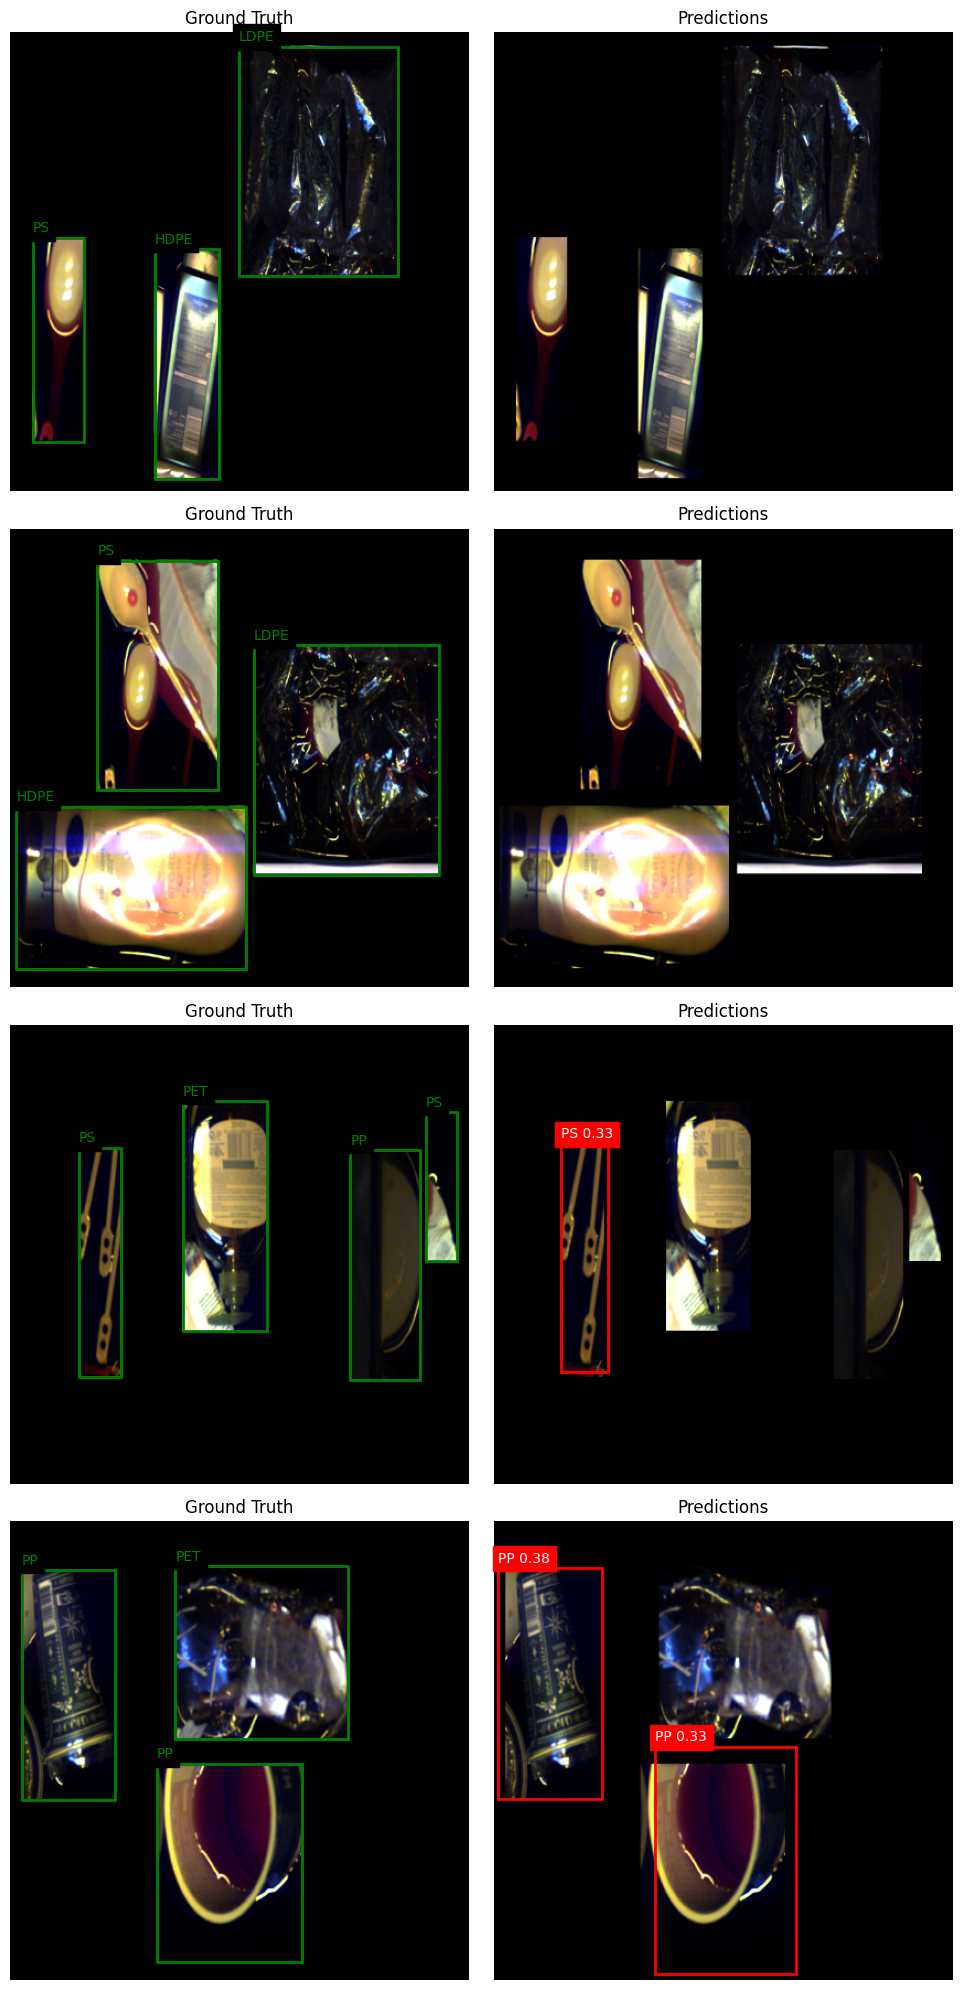

In [14]:
#@title 12  Compare Ground Truth vs Predictions on Test Set (GPU)
import torch
from torchvision.ops import nms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Send model back to GPU
model.to(device).eval()

# 2) Prepare test DataLoader
test_ds = YoloFolderDataset("test")
test_ld = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

def decode_ground_truth(label, anchors, image_size):
    Gh, Gw, A, _ = label.shape
    device = label.device

    tx, ty = label[...,0], label[...,1]
    tw, th = label[...,2], label[...,3]
    obj_mask = label[...,4] == 1
    cls_idx = label[...,5:].argmax(dim=-1)

    yv, xv = torch.meshgrid(
        torch.arange(Gh, device=device),
        torch.arange(Gw, device=device),
        indexing='ij'
    )
    xv = xv.unsqueeze(-1).float()
    yv = yv.unsqueeze(-1).float()

    bx = (xv + tx) / Gw
    by = (yv + ty) / Gh

    anchors_t = torch.tensor(anchors, device=device).view(1,1,A,2)
    bw = anchors_t[...,0] * torch.exp(tw)
    bh = anchors_t[...,1] * torch.exp(th)

    img_h, img_w = image_size
    x1 = ((bx - bw/2) * img_w).reshape(-1)
    y1 = ((by - bh/2) * img_h).reshape(-1)
    x2 = ((bx + bw/2) * img_w).reshape(-1)
    y2 = ((by + bh/2) * img_h).reshape(-1)

    cls_idx = cls_idx.reshape(-1)
    mask = obj_mask.reshape(-1)
    keep = mask.nonzero(as_tuple=True)[0]

    boxes   = torch.stack([x1, y1, x2, y2], dim=1)[keep]
    classes = cls_idx[keep]
    return boxes, classes

def non_max_suppression(preds, anchors, image_size, conf_thres=0.3, iou_thres=0.5):
    Gh, Gw, A, _ = preds.shape
    device = preds.device

    tx, ty = preds[...,0], preds[...,1]
    tw, th = preds[...,2], preds[...,3]
    obj_logits = preds[...,4]
    cls_logits = preds[...,5:]

    yv, xv = torch.meshgrid(
        torch.arange(Gh, device=device),
        torch.arange(Gw, device=device),
        indexing='ij'
    )
    xv = xv.unsqueeze(-1).float()
    yv = yv.unsqueeze(-1).float()

    bx = (xv + torch.sigmoid(tx)) / Gw
    by = (yv + torch.sigmoid(ty)) / Gh
    anchors_t = torch.tensor(anchors, device=device).view(1,1,A,2)
    bw = anchors_t[...,0] * torch.exp(tw)
    bh = anchors_t[...,1] * torch.exp(th)

    img_h, img_w = image_size
    x1 = ((bx - bw/2) * img_w).reshape(-1)
    y1 = ((by - bh/2) * img_h).reshape(-1)
    x2 = ((bx + bw/2) * img_w).reshape(-1)
    y2 = ((by + bh/2) * img_h).reshape(-1)

    obj_prob = torch.sigmoid(obj_logits).reshape(-1)
    cls_prob = torch.sigmoid(cls_logits).reshape(-1, cls_logits.shape[-1])
    cls_conf, cls_idx = cls_prob.max(dim=1)
    scores = obj_prob * cls_conf

    boxes = torch.stack([x1, y1, x2, y2], dim=1)
    keep = scores > conf_thres
    boxes, scores, cls_idx = boxes[keep], scores[keep], cls_idx[keep]

    detections = []
    for c in cls_idx.unique():
        mask_c = (cls_idx == c)
        b = boxes[mask_c]
        s = scores[mask_c]
        keep_idx = nms(b, s, iou_thres)
        for idx in keep_idx:
            x1_, y1_, x2_, y2_ = b[idx].cpu().tolist()
            detections.append([x1_, y1_, x2_, y2_, s[idx].item(), int(c.item())])
    return detections

# 3) Fetch one batch from test set
imgs, labels = next(iter(test_ld))
imgs  = imgs.to(device)
labels = labels.to(device)
preds  = model(imgs)

# 4) Plot side by side
num_show = imgs.size(0)
fig, axs = plt.subplots(num_show, 2, figsize=(10, 5*num_show))
for i in range(num_show):
    img = imgs[i].permute(1,2,0).cpu().numpy()

    # Ground Truth
    ax = axs[i,0]
    ax.imshow(img); ax.set_title("Ground Truth"); ax.axis('off')
    gt_boxes, gt_classes = decode_ground_truth(labels[i], ANCHORS, IMAGE_SIZE)
    for (x1,y1,x2,y2), cls in zip(gt_boxes, gt_classes):
        x1f,y1f,x2f,y2f = [v.item() for v in (x1,y1,x2,y2)]
        rect = plt.Rectangle((x1f,y1f), x2f-x1f, y2f-y1f,
                             edgecolor='green', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1f, y1f-5, CLASS_NAMES[cls.item()],
                color='green', fontsize=10, backgroundcolor='black')

    # Predictions
    ax = axs[i,1]
    ax.imshow(img); ax.set_title("Predictions"); ax.axis('off')
    dets = non_max_suppression(preds[i], ANCHORS, IMAGE_SIZE,
                                conf_thres=0.3, iou_thres=0.5)
    for x1,y1,x2,y2,score,cls in dets:
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{CLASS_NAMES[cls]} {score:.2f}",
                color='white', backgroundcolor='red', fontsize=10)

plt.tight_layout()

In [15]:
#@title 13b  Evaluate full COCO-style metrics on CPU
from torchvision.ops import nms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

# Prepare CPU model
device_eval = torch.device('cpu')
model_cpu = model.to(device_eval)

# Prepare DataLoader
test_ds = YoloFolderDataset("test")
test_ld = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=False)

# Metric
map_metric = MeanAveragePrecision()

def decode_pred(pred, conf_thres=0.2, iou_thres=0.5):
    """
    Turn one (Gh, Gw, A, 5+C) tensor into final boxes, scores, labels with NMS.
    """
    Gh, Gw, A, _ = pred.shape
    device = pred.device

    # split out predictions
    tx, ty = pred[...,0], pred[...,1]
    tw, th = pred[...,2], pred[...,3]
    obj_logits = pred[...,4]
    cls_logits = pred[...,5:]        # (Gh, Gw, A, C)

    # build grid
    yv, xv = torch.meshgrid(
        torch.arange(Gh, device=device, dtype=torch.float32),
        torch.arange(Gw, device=device, dtype=torch.float32),
        indexing='ij'
    )
    xv = xv.unsqueeze(-1)
    yv = yv.unsqueeze(-1)

    # decode to center / size
    bx = (xv + torch.sigmoid(tx)) / Gw
    by = (yv + torch.sigmoid(ty)) / Gh
    anchors_t = torch.tensor(ANCHORS, device=device).view(1,1,A,2)
    bw = anchors_t[...,0] * torch.exp(tw)
    bh = anchors_t[...,1] * torch.exp(th)

    # corner coordinates in pixel space
    img_h, img_w = IMAGE_SIZE
    x1 = ((bx - bw/2) * img_w).reshape(-1)
    y1 = ((by - bh/2) * img_h).reshape(-1)
    x2 = ((bx + bw/2) * img_w).reshape(-1)
    y2 = ((by + bh/2) * img_h).reshape(-1)

    # objectness and class scores
    obj_prob = torch.sigmoid(obj_logits).reshape(-1)
    cls_prob = torch.sigmoid(cls_logits).reshape(-1, cls_logits.shape[-1])
    cls_conf, cls_idx = cls_prob.max(dim=1)
    scores = obj_prob * cls_conf

    # pack boxes, scores, labels
    boxes  = torch.stack([x1,y1,x2,y2], dim=1)
    labels = cls_idx
    # threshold
    mask = scores > conf_thres
    if not mask.any():
        return torch.zeros((0,4)), torch.tensor([], dtype=torch.float32), torch.tensor([], dtype=torch.int64)
    boxes  = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    # apply NMS per class
    keep_boxes, keep_scores, keep_labels = [], [], []
    for c in labels.unique():
        idxs = (labels == c).nonzero(as_tuple=True)[0]
        b = boxes[idxs]
        s = scores[idxs]
        kept = nms(b, s, iou_thres)
        for k in kept:
            keep_boxes.append(b[k])
            keep_scores.append(s[k])
            keep_labels.append(c)
    if not keep_boxes:
        return torch.zeros((0,4)), torch.tensor([], dtype=torch.float32), torch.tensor([], dtype=torch.int64)
    return torch.stack(keep_boxes), torch.stack(keep_scores), torch.stack(keep_labels)
def decode_gt(gt):
    """
    Turn one (Gh, Gw, A, 5+C) GT tensor into boxes & labels lists.
    """
    Gh, Gw, A, _ = gt.shape
    device = gt.device
    boxes, labels = [], []

    for i in range(Gh):
        for j in range(Gw):
            for a in range(A):
                # objectness flag at index 4
                if gt[i, j, a, 4].item() != 1:
                    continue

                # read the encoded offsets
                dx = gt[i, j, a, 0].item()
                dy = gt[i, j, a, 1].item()
                tw = gt[i, j, a, 2].item()
                th = gt[i, j, a, 3].item()

                # decode center in pixels
                cx = (j + dx) / Gw * IMAGE_SIZE[1]
                cy = (i + dy) / Gh * IMAGE_SIZE[0]
                # decode width & height in pixels
                w = math.exp(tw) * ANCHORS[a][0] * IMAGE_SIZE[1]
                h = math.exp(th) * ANCHORS[a][1] * IMAGE_SIZE[0]

                x1 = cx - w/2
                y1 = cy - h/2
                x2 = cx + w/2
                y2 = cy + h/2

                # class ID is the argmax of the one-hot slice
                cls_id = int(gt[i, j, a, 5:5+C].argmax().item())

                boxes.append([x1, y1, x2, y2])
                labels.append(cls_id)

    if not boxes:
        return torch.zeros((0,4)), torch.tensor([], dtype=torch.int64)

    return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)


model_cpu.eval()
with torch.no_grad():
    for imgs, gts in tqdm(test_ld, desc="Evaluating"):
        imgs_cpu = imgs.to(device_eval)
        preds = model_cpu(imgs_cpu).cpu()
        for pred, gt in zip(preds, gts):
            pb, ps, pl = decode_pred(pred, conf_thres=0.2, iou_thres=0.5)
            gb, gl     = decode_gt(gt)
            map_metric.update(
                [{"boxes": pb, "scores": ps, "labels": pl}],
                [{"boxes": gb,  "labels": gl}]
            )

results = map_metric.compute()
print(f"mAP @[0.50:0.95] = {results['map']:.4f}")
print(f"mAP @0.50       = {results['map_50']:.4f}")
print(f"mAP @0.75       = {results['map_75']:.4f}")

Evaluating: 100%|██████████| 4/4 [00:21<00:00,  5.30s/it]

mAP @[0.50:0.95] = 0.2624
mAP @0.50       = 0.5301
mAP @0.75       = 0.2284


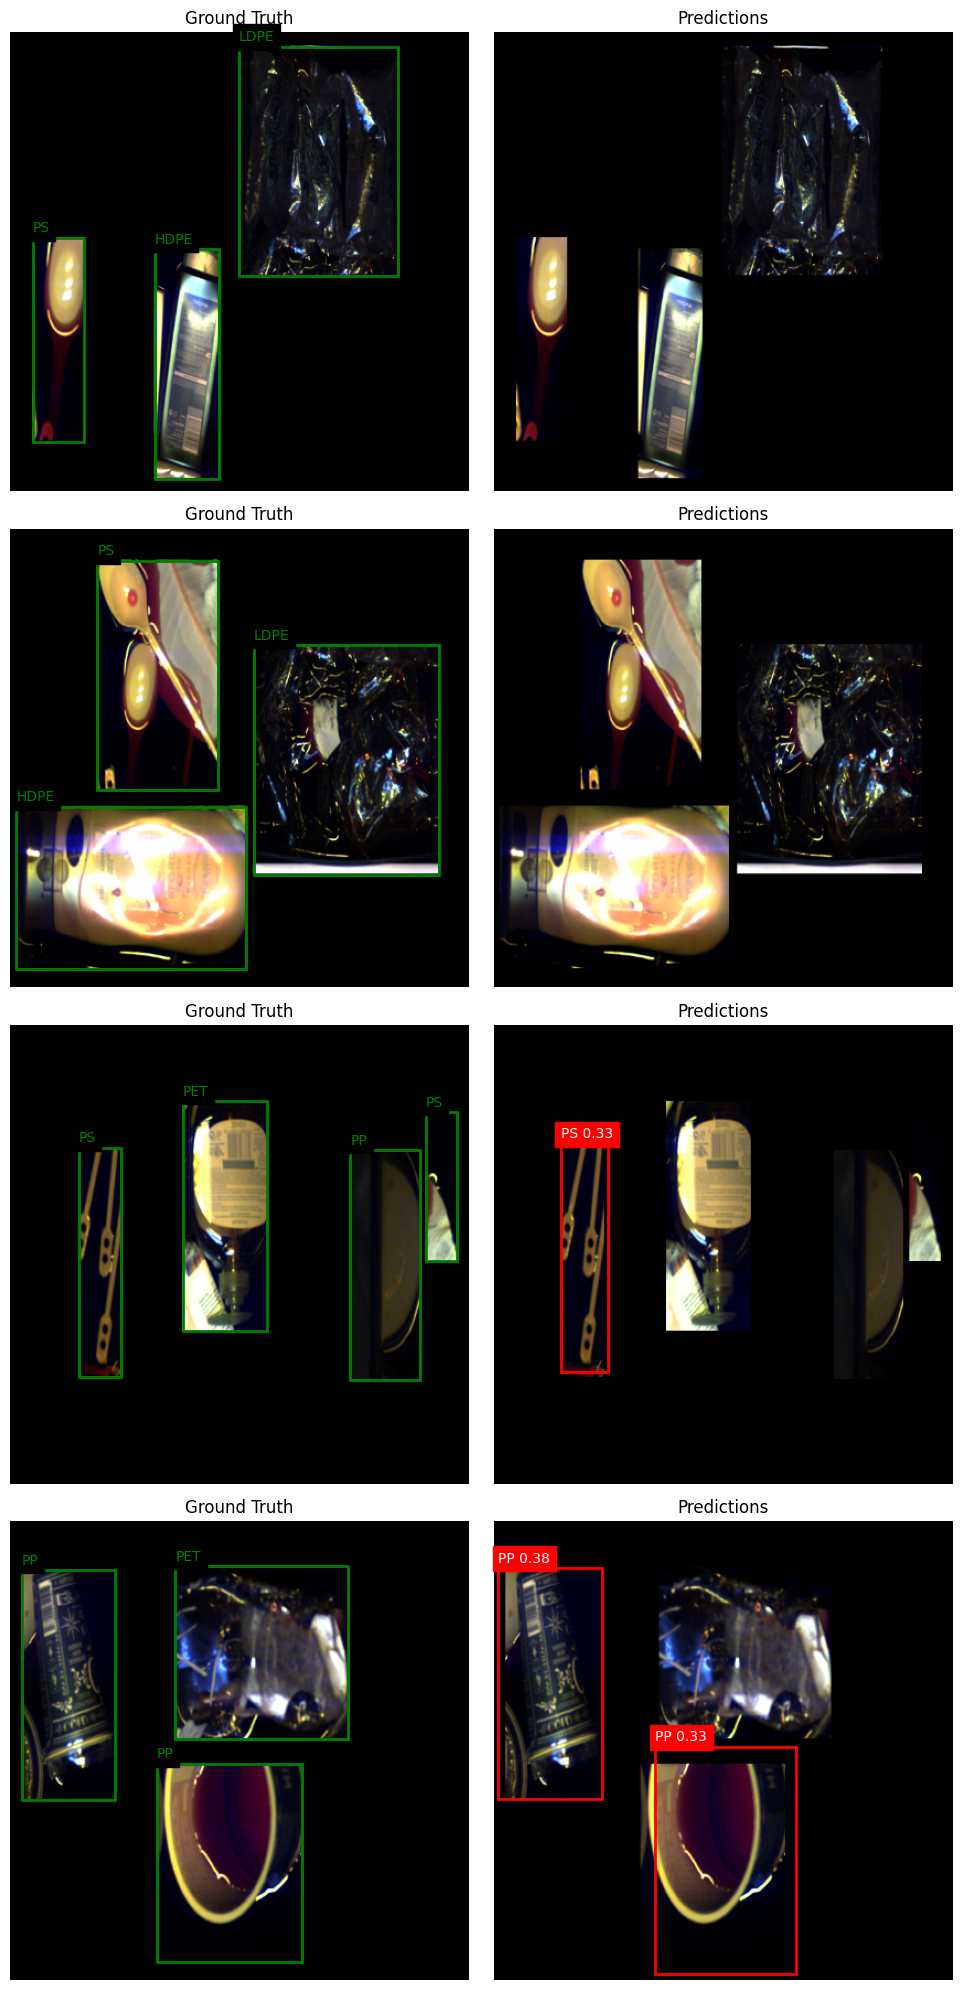

In [16]:
#@title 12  Compare Ground Truth vs Predictions on Test Set (GPU)
import torch
from torchvision.ops import nms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Send model back to GPU
model.to(device).eval()

# 2) Prepare test DataLoader
test_ds = YoloFolderDataset("test")
test_ld = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

def decode_ground_truth(label, anchors, image_size):
    Gh, Gw, A, _ = label.shape
    device = label.device

    tx, ty = label[...,0], label[...,1]
    tw, th = label[...,2], label[...,3]
    obj_mask = label[...,4] == 1
    cls_idx = label[...,5:].argmax(dim=-1)

    yv, xv = torch.meshgrid(
        torch.arange(Gh, device=device),
        torch.arange(Gw, device=device),
        indexing='ij'
    )
    xv = xv.unsqueeze(-1).float()
    yv = yv.unsqueeze(-1).float()

    bx = (xv + tx) / Gw
    by = (yv + ty) / Gh

    anchors_t = torch.tensor(anchors, device=device).view(1,1,A,2)
    bw = anchors_t[...,0] * torch.exp(tw)
    bh = anchors_t[...,1] * torch.exp(th)

    img_h, img_w = image_size
    x1 = ((bx - bw/2) * img_w).reshape(-1)
    y1 = ((by - bh/2) * img_h).reshape(-1)
    x2 = ((bx + bw/2) * img_w).reshape(-1)
    y2 = ((by + bh/2) * img_h).reshape(-1)

    cls_idx = cls_idx.reshape(-1)
    mask = obj_mask.reshape(-1)
    keep = mask.nonzero(as_tuple=True)[0]

    boxes   = torch.stack([x1, y1, x2, y2], dim=1)[keep]
    classes = cls_idx[keep]
    return boxes, classes

def non_max_suppression(preds, anchors, image_size, conf_thres=0.3, iou_thres=0.5):
    Gh, Gw, A, _ = preds.shape
    device = preds.device

    tx, ty = preds[...,0], preds[...,1]
    tw, th = preds[...,2], preds[...,3]
    obj_logits = preds[...,4]
    cls_logits = preds[...,5:]

    yv, xv = torch.meshgrid(
        torch.arange(Gh, device=device),
        torch.arange(Gw, device=device),
        indexing='ij'
    )
    xv = xv.unsqueeze(-1).float()
    yv = yv.unsqueeze(-1).float()

    bx = (xv + torch.sigmoid(tx)) / Gw
    by = (yv + torch.sigmoid(ty)) / Gh
    anchors_t = torch.tensor(anchors, device=device).view(1,1,A,2)
    bw = anchors_t[...,0] * torch.exp(tw)
    bh = anchors_t[...,1] * torch.exp(th)

    img_h, img_w = image_size
    x1 = ((bx - bw/2) * img_w).reshape(-1)
    y1 = ((by - bh/2) * img_h).reshape(-1)
    x2 = ((bx + bw/2) * img_w).reshape(-1)
    y2 = ((by + bh/2) * img_h).reshape(-1)

    obj_prob = torch.sigmoid(obj_logits).reshape(-1)
    cls_prob = torch.sigmoid(cls_logits).reshape(-1, cls_logits.shape[-1])
    cls_conf, cls_idx = cls_prob.max(dim=1)
    scores = obj_prob * cls_conf

    boxes = torch.stack([x1, y1, x2, y2], dim=1)
    keep = scores > conf_thres
    boxes, scores, cls_idx = boxes[keep], scores[keep], cls_idx[keep]

    detections = []
    for c in cls_idx.unique():
        mask_c = (cls_idx == c)
        b = boxes[mask_c]
        s = scores[mask_c]
        keep_idx = nms(b, s, iou_thres)
        for idx in keep_idx:
            x1_, y1_, x2_, y2_ = b[idx].cpu().tolist()
            detections.append([x1_, y1_, x2_, y2_, s[idx].item(), int(c.item())])
    return detections

# 3) Fetch one batch from test set
imgs, labels = next(iter(test_ld))
imgs  = imgs.to(device)
labels = labels.to(device)
preds  = model(imgs)

# 4) Plot side by side
num_show = imgs.size(0)
fig, axs = plt.subplots(num_show, 2, figsize=(10, 5*num_show))
for i in range(num_show):
    img = imgs[i].permute(1,2,0).cpu().numpy()

    # Ground Truth
    ax = axs[i,0]
    ax.imshow(img); ax.set_title("Ground Truth"); ax.axis('off')
    gt_boxes, gt_classes = decode_ground_truth(labels[i], ANCHORS, IMAGE_SIZE)
    for (x1,y1,x2,y2), cls in zip(gt_boxes, gt_classes):
        x1f,y1f,x2f,y2f = [v.item() for v in (x1,y1,x2,y2)]
        rect = plt.Rectangle((x1f,y1f), x2f-x1f, y2f-y1f,
                             edgecolor='green', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1f, y1f-5, CLASS_NAMES[cls.item()],
                color='green', fontsize=10, backgroundcolor='black')

    # Predictions
    ax = axs[i,1]
    ax.imshow(img); ax.set_title("Predictions"); ax.axis('off')
    dets = non_max_suppression(preds[i], ANCHORS, IMAGE_SIZE,
                                conf_thres=0.3, iou_thres=0.5)
    for x1,y1,x2,y2,score,cls in dets:
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{CLASS_NAMES[cls]} {score:.2f}",
                color='white', backgroundcolor='red', fontsize=10)

plt.tight_layout()